In [1]:
import json
import os
import dotenv
# os.environ['PATH_TO_ENV'] = "~/projects/chatsky-llm-autoconfig/.env"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dialogue2graph import metrics
from dialogue2graph.pipelines.core.graph import Graph
from dialogue2graph.pipelines.model_storage import ModelStorage
from dialogue2graph.pipelines.helpers.parse_data import PipelineRawDataType

/home/peshkichev/miniconda3/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


In [4]:
dotenv.load_dotenv()

True

In [5]:
ms = ModelStorage()

In [6]:
ms.add(
        key="grouping_llm",
        config={"model_name": "chatgpt-4o-latest", "temperature": 0, "api_key": os.getenv("OPENAI_API_KEY"), "base_url": os.getenv("OPENAI_BASE_URL")},
        model_type="llm",
    )    
ms.add(
        key="extending_llm",
        config={"model_name": "chatgpt-4o-latest", "temperature": 0, "api_key": os.getenv("OPENAI_API_KEY"), "base_url": os.getenv("OPENAI_BASE_URL")},
        model_type="llm",
    )    
ms.add(
        key="filling_llm",
        config={"model_name": "o3-mini", "temperature": 1, "api_key": os.getenv("OPENAI_API_KEY"), "base_url": os.getenv("OPENAI_BASE_URL")},
        model_type="llm",
    )
ms.add(
        key="formatting_llm",
        config={"model_name": "gpt-4o-mini", "temperature": 0, "api_key": os.getenv("OPENAI_API_KEY"), "base_url": os.getenv("OPENAI_BASE_URL")},
        model_type="llm",
    )
ms.add(
        key="sim_model",
        config={"model_name": "BAAI/bge-m3", "device": "cuda:0"},
        model_type="emb",
    )


INFO:dialogue2graph.pipelines.model_storage:Added llm model 'grouping_llm' to storage


INFO:dialogue2graph.pipelines.model_storage:Added llm model 'extending_llm' to storage
INFO:dialogue2graph.pipelines.model_storage:Added llm model 'filling_llm' to storage
INFO:dialogue2graph.pipelines.model_storage:Added llm model 'formatting_llm' to storage
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3
INFO:dialogue2graph.pipelines.model_storage:Added emb model 'sim_model' to storage


### D2G Algo pipeline

In [7]:
from dialogue2graph.pipelines.d2g_light.pipeline import Pipeline

/home/peshkichev/miniconda3/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function callable> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [8]:
pipeline = Pipeline(
        name="d2g_light",
        model_storage=ms,
        filling_llm="filling_llm",
        formatting_llm="formatting_llm",
        sim_model="sim_model",
        step2_evals=metrics.DGEvalBase,
        end_evals=metrics.DGEvalBase
        )

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


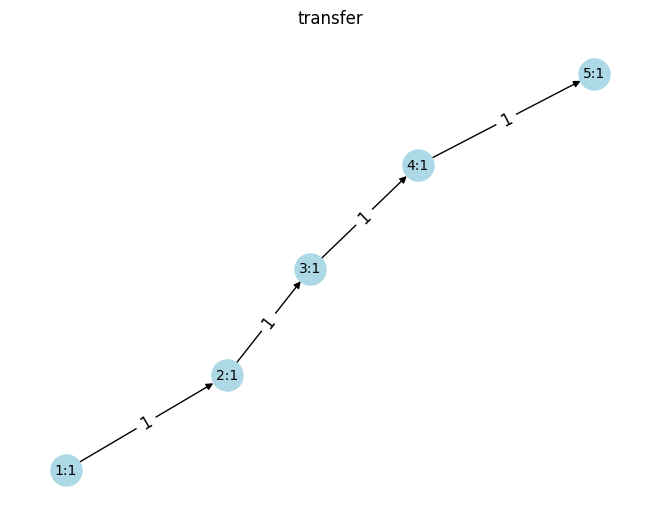

In [9]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [8]:
report

PipelineReport(service='d2g_light', properties={'time': 0.3511824607849121}, step_reports=[{}])

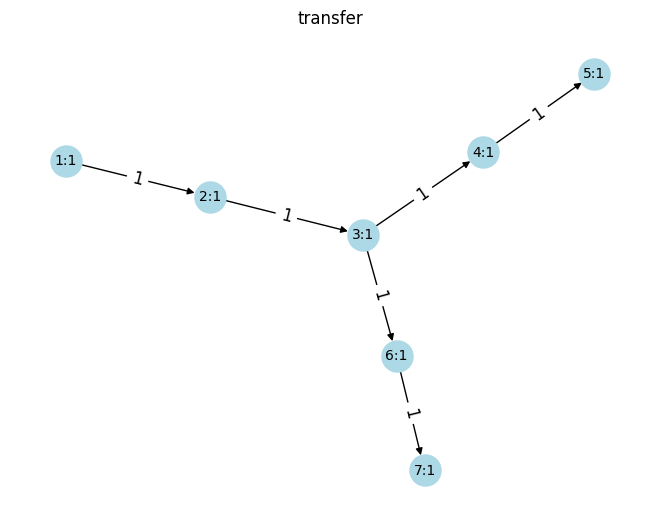

In [10]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}],
   [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

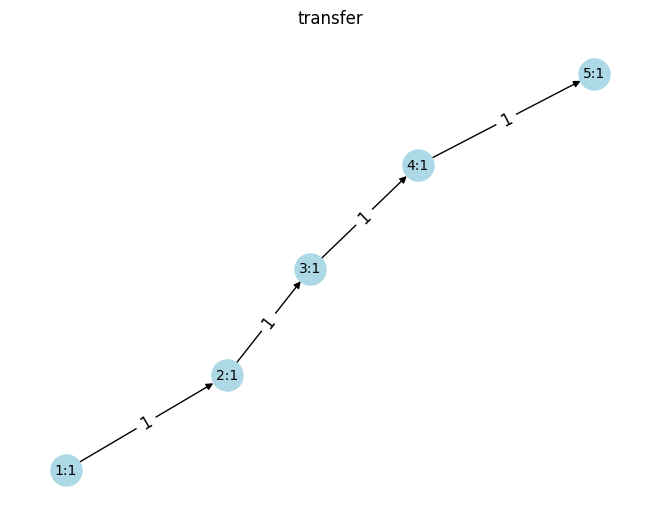

In [11]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

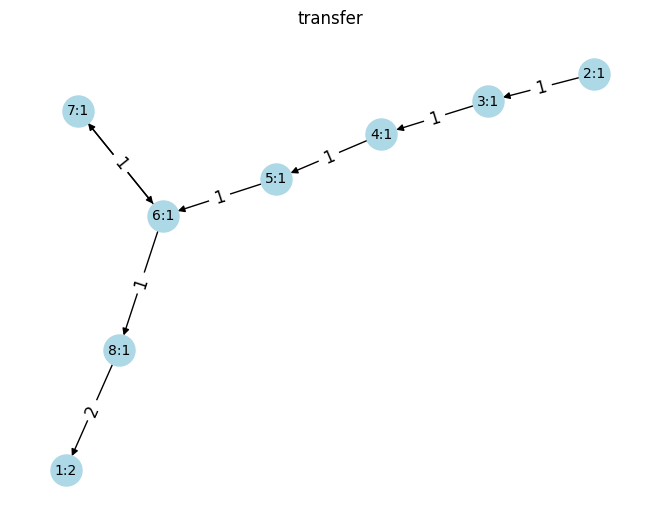

In [12]:
with open('transfer.json') as f:
    data = json.load(f)

raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

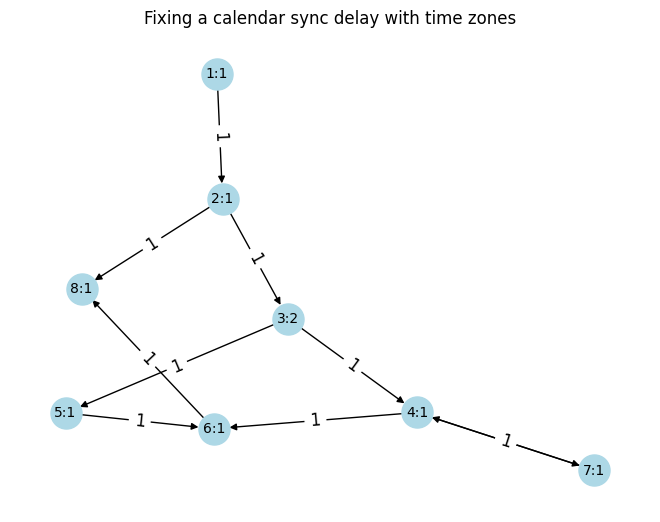

In [18]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
Graph(data['true_graph']).visualise_short("Fixing a calendar sync delay with time zones")

In [19]:
metrics.llm_metrics.compare_graphs(Graph(data['true_graph']), graph)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'value': True,
 'description': 'Nodes similarity: 0.9999998807907104, Nodes+edges similarity: 0.9870117902755737'}

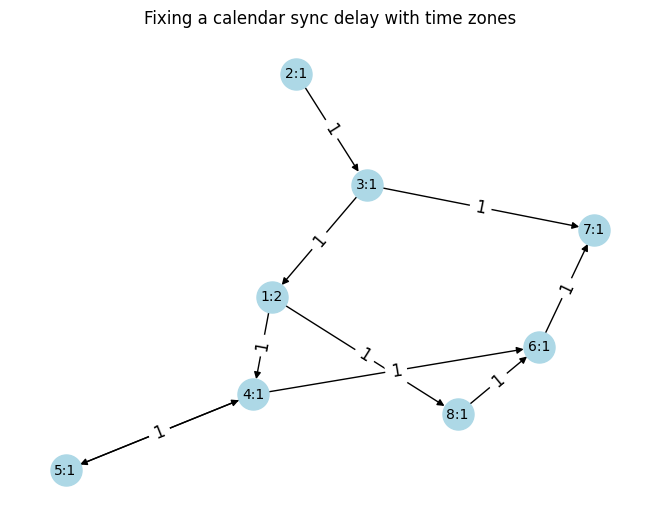

In [14]:
raw_data = PipelineRawDataType(dialogs="test_graph_1.json")
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("Fixing a calendar sync delay with time zones")

In [15]:
report

PipelineReport(service='d2g_light', properties={'time': 2.5720553398132324, 'simple_graph_comparison': False}, subreports=[{}])

In [23]:
raw_data = PipelineRawDataType(dialogs=data['dialogs'], true_graph=data['true_graph'])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

GRAPH:  {'nodes': [{'id': 1, 'label': '', 'is_start': False, 'utterances': ['Could you verify that the time zone settings are properly configured on your devices?', 'Have you checked if your time zone settings are correct on all your devices?']}, {'id': 2, 'label': '', 'is_start': True, 'utterances': ['Hello! How can I assist you with your calendar today?']}, {'id': 3, 'label': '', 'is_start': False, 'utterances': ["I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"]}, {'id': 4, 'label': '', 'is_start': False, 'utterances': ['Sure, let me guide you through adjusting your time zone settings.']}, {'id': 5, 'label': '', 'is_start': False, 'utterances': ['Of course! Which device would you like to adjust the time zone settings on?']}, {'id': 6, 'label': '', 'is_start': False, 'utterances': ['Great! Is your calendar syncing correctly now?']}, {'id': 7, 'label': '', 'is_start': False, 'utterances': ["I'm sorry we couldn't resolve the issue. If you need 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PipelineReport(service='d2g_light', properties={'time': 8.666953563690186, 'simple_graph_comparison': True, 'complex_graph_comparison': {'value': True, 'description': 'Nodes similarity: 0.9999998807907104, Nodes+edges similarity: 0.9870117902755737'}}, step_reports=[{'compare_graphs:step2': {'value': True, 'description': 'Nodes similarity: 0.9999998807907104, Nodes+edges similarity: 0.9870117902755737'}, 'is_same_structure:step2': True}])

### D2G LLM pipeline

In [9]:
from dialogue2graph.pipelines.d2g_llm.pipeline import Pipeline
pipeline = Pipeline(
        name="d2g_llm",
        model_storage=ms,
        grouping_llm="grouping_llm",
        filling_llm="filling_llm",
        formatting_llm="formatting_llm",
        sim_model="sim_model",
        step2_evals=metrics.DGEvalBase,
        end_evals=metrics.DGEvalBase
        )

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


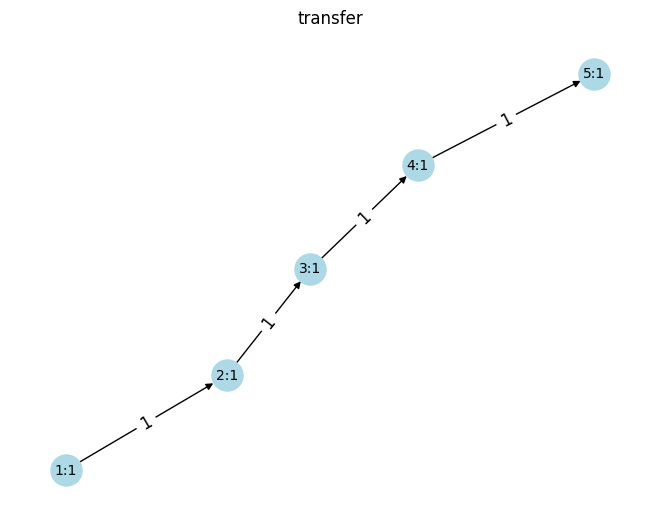

In [10]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


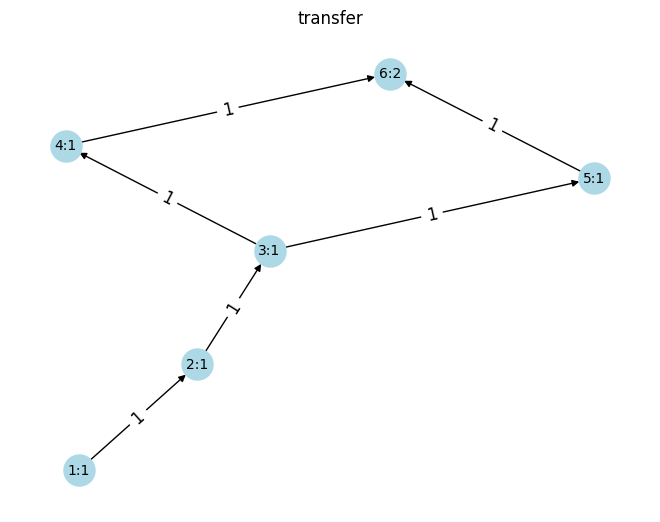

In [12]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}],
   [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


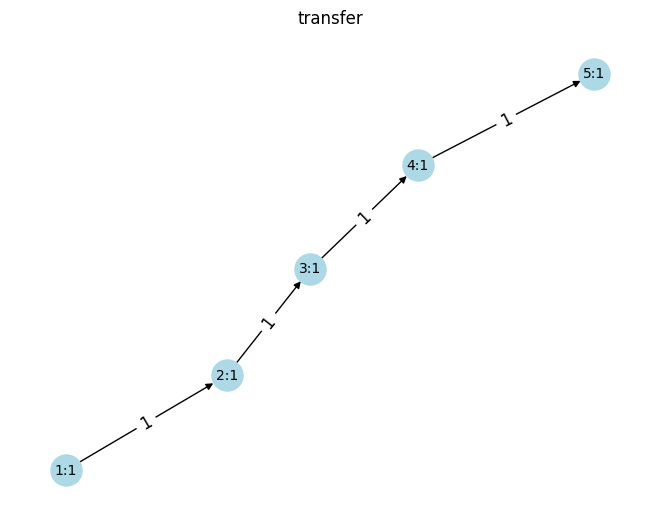

In [13]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [29]:
data

[{'messages': [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'My flight is on Saturday at 10 AM from JFK.',
    'participant': 'user'},
   {'text': 'Got it. Where should the driver pick you up?',
    'participant': 'assistant'},
   {'text': 'Pickup is from my home in Brooklyn.', 'participant': 'user'},
   {'text': 'Thanks! How many passengers will be traveling?',
    'participant': 'assistant'},
   {'text': "It's just me traveling.", 'participant': 'user'},
   {'text': 'Alright! Do you have any preference for the type of vehicle? We have sedans, SUVs, and vans available.',
    'participant': 'assistant'},
   {'text': 'Actually, can I change my vehicle type?', 'participant': 'user'},
   {'text': 'Of course! What type of vehicle would y

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


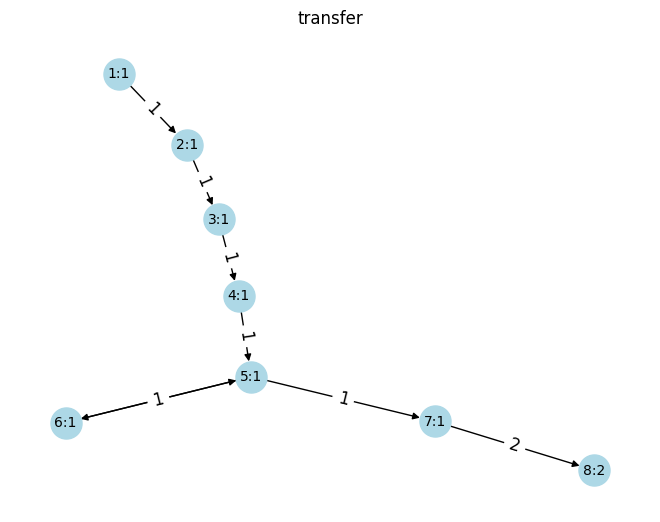

In [14]:
with open('transfer.json') as f:
    data = json.load(f)
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [17]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
raw_data = PipelineRawDataType(dialogs=data['dialogs'], true_graph=data['true_graph'])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

GRAPH:  {'nodes': [{'id': 1, 'label': 'greeting', 'is_start': True, 'utterances': ['Hello! How can I assist you with your calendar today?']}, {'id': 2, 'label': 'acknowledge_issue', 'is_start': False, 'utterances': ["I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"]}, {'id': 3, 'label': 'ask_timezone_check', 'is_start': False, 'utterances': ['Could you verify that the time zone settings are properly configured on your devices?', 'Have you checked if your time zone settings are correct on all your devices?']}, {'id': 4, 'label': 'guide_timezone_adjustment', 'is_start': False, 'utterances': ['Sure, let me guide you through adjusting your time zone settings.']}, {'id': 5, 'label': 'ask_device_for_timezone', 'is_start': False, 'utterances': ['Of course! Which device would you like to adjust the time zone settings on?']}, {'id': 6, 'label': 'suggest_refresh_or_reinstall', 'is_start': False, 'utterances': ['If time zone settings are correct, we can t

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PipelineReport(service='d2g_llm', properties={'time': 11.179451704025269, 'simple_graph_comparison': True, 'complex_graph_comparison': {'value': True, 'description': 'Nodes similarity: 0.9999998807907104, Nodes+edges similarity: 0.9870117902755737'}}, subreports=[{'compare_graphs:step2': {'value': True, 'description': 'Nodes similarity: 0.9999998807907104, Nodes+edges similarity: 0.9870117902755737'}, 'is_same_structure:step2': True}])

### D2G LLM extender

In [7]:
from dialogue2graph.pipelines.d2g_extender.pipeline import Pipeline
pipeline = Pipeline(
        name="d2g_ext",
        model_storage=ms,
        extending_llm="extending_llm",
        filling_llm="filling_llm",
        formatting_llm="formatting_llm",
        sim_model="sim_model",
        step1_evals=metrics.PreDGEvalBase,
        extender_evals=metrics.PreDGEvalBase,
        step2_evals=metrics.DGEvalBase,
        end_evals=metrics.DGEvalBase
        )

/home/peshkichev/miniconda3/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function callable> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [6]:
raw_data

PipelineRawDataType(dialogs=[{'text': 'Hey there! How can I help you today?', 'participant': 'assistant'}, {'text': 'I need to book a ride to the airport.', 'participant': 'user'}, {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?', 'participant': 'assistant'}, {'text': 'Do you have any other options?', 'participant': 'user'}, {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?", 'participant': 'assistant'}, {'text': "No, I'll manage on my own.", 'participant': 'user'}, {'text': 'No worries! Feel free to reach out anytime.', 'participant': 'assistant'}, {'text': 'Alright, thanks anyway.', 'participant': 'user'}, {'text': "You're welcome! Have a fantastic trip!", 'participant': 'assistant'}], supported_graph=None, true_graph=None)

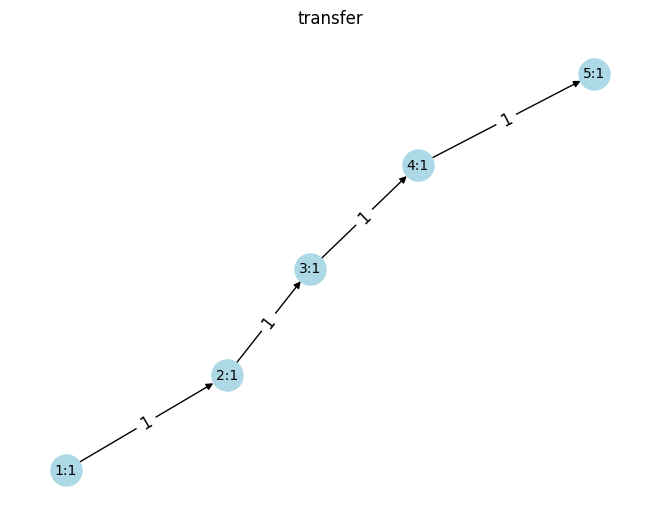

In [12]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

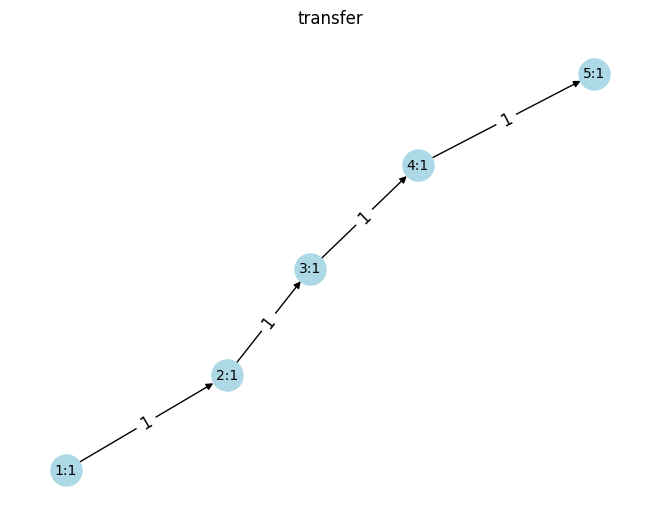

In [20]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}]]
raw_data = PipelineRawDataType(dialogs=data, supported_graph=graph.graph_dict)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

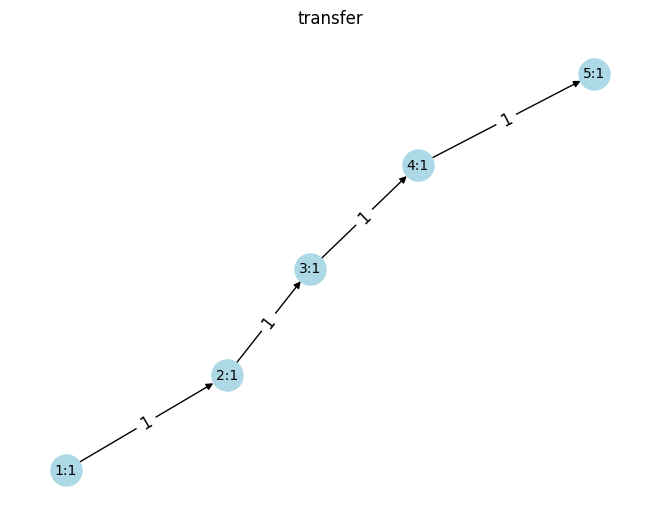

In [21]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


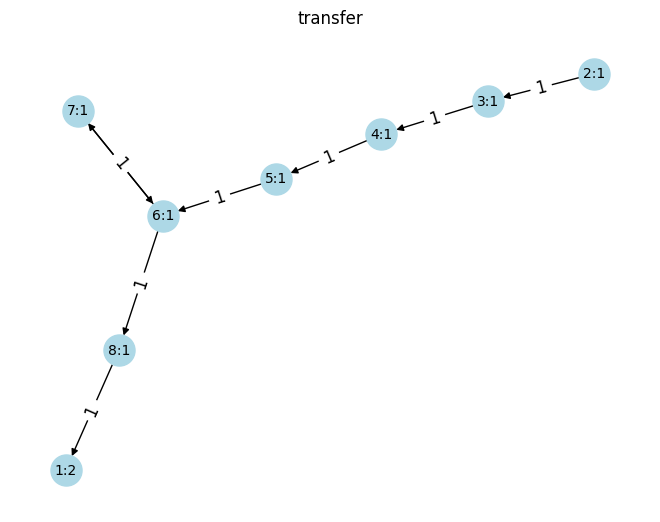

In [8]:
with open('transfer.json') as f:
    data = json.load(f)
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

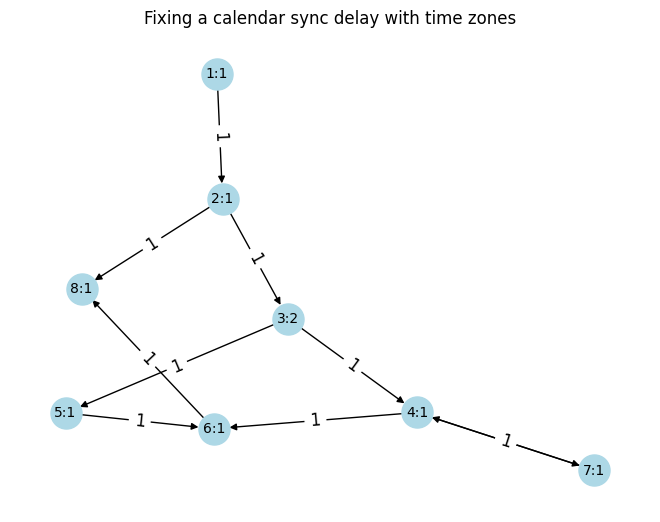

In [83]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
Graph(data['true_graph']).visualise_short("Fixing a calendar sync delay with time zones")

In [48]:
data

[{'graph': {'edges': [{'source': 1,
     'target': 2,
     'utterances': ["I'm having trouble with my calendar not syncing properly."]},
    {'source': 2,
     'target': 3,
     'utterances': ["Yes, I checked but it still doesn't sync."]},
    {'source': 3,
     'target': 4,
     'utterances': ['Alright, please guide me through the steps.']},
    {'source': 4,
     'target': 6,
     'utterances': ["I've followed the steps and it seems to be working now."]},
    {'source': 2,
     'target': 8,
     'utterances': ["I think I'll handle it later. Thanks anyway."]},
    {'source': 4,
     'target': 7,
     'utterances': ['I want to change the time zone instead.']},
    {'source': 7,
     'target': 4,
     'utterances': ["Sure, let's adjust the time zone settings."]},
    {'source': 5,
     'target': 6,
     'utterances': ["After adjusting, it still doesn't sync."]},
    {'source': 3,
     'target': 5,
     'utterances': ['Time zone settings are correct, but the issue persists.']},
    {'sou

In [20]:
lst=  [[], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': 'i want to change the time zone instead.'}, {'participant': 'assistant', 'text': 'Of course! Which device would you like to adjust the time zone settings on?'}, {'participant': 'user', 'text': "sure, let's adjust the time zone settings."}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': 'i want to change the time zone instead.'}, {'participant': 'assistant', 'text': 'Of course! Which device would you like to adjust the time zone settings on?'}, {'participant': 'user', 'text': "sure, let's adjust the time zone settings."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': 'i want to change the time zone instead.'}, {'participant': 'assistant', 'text': 'Of course! Which device would you like to adjust the time zone settings on?'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': 'i want to change the time zone instead.'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}]]
lst

[[],
 [{},
  {'participant': 'assistant',
   'text': 'Hello! How can I assist you with your calendar today?'},
  {'participant': 'user',
   'text': "i'm having trouble with my calendar not syncing properly."},
  {'participant': 'assistant',
   'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"},
  {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."},
  {'participant': 'assistant',
   'text': 'Could you verify that the time zone settings are properly configured on your devices?'},
  {'participant': 'user',
   'text': 'alright, please guide me through the steps.'},
  {'participant': 'assistant',
   'text': 'Sure, let me guide you through adjusting your time zone settings.'},
  {'participant': 'user', 'text': 'i want to change the time zone instead.'},
  {'participant': 'assistant',
   'text': 'Of course! Which device would you like to adjust the time zone settings on?'},
  {'participant': 'user',
   'text': "sure, l

In [21]:
len(lst)

8

In [37]:
lst_3[0]

[{},
 {'participant': 'assistant',
  'text': 'Hello! How can I assist you with your calendar today?'},
 {'participant': 'user',
  'text': "i'm having trouble with my calendar not syncing properly."},
 {'participant': 'assistant',
  'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"},
 {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."},
 {'participant': 'assistant',
  'text': 'Could you verify that the time zone settings are properly configured on your devices?'},
 {'participant': 'user',
  'text': 'alright, please guide me through the steps.'},
 {'participant': 'assistant',
  'text': 'Sure, let me guide you through adjusting your time zone settings.'},
 {'participant': 'user',
  'text': "i've followed the steps and it seems to be working now."},
 {'participant': 'assistant',
  'text': 'Great! Is your calendar syncing correctly now?'},
 {'participant': 'user',
  'text': "actually, it's still not syncing. i want t

In [38]:
len(lst_3[0])

12

In [33]:
len(lst[1])

12

In [34]:
lst_3[0]==lst[1]

True

In [28]:
lst[1]

[{},
 {'participant': 'assistant',
  'text': 'Hello! How can I assist you with your calendar today?'},
 {'participant': 'user',
  'text': "i'm having trouble with my calendar not syncing properly."},
 {'participant': 'assistant',
  'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"},
 {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."},
 {'participant': 'assistant',
  'text': 'Could you verify that the time zone settings are properly configured on your devices?'},
 {'participant': 'user',
  'text': 'alright, please guide me through the steps.'},
 {'participant': 'assistant',
  'text': 'Sure, let me guide you through adjusting your time zone settings.'},
 {'participant': 'user', 'text': 'i want to change the time zone instead.'},
 {'participant': 'assistant',
  'text': 'Of course! Which device would you like to adjust the time zone settings on?'},
 {'participant': 'user', 'text': "sure, let's adjust the time zone 

In [23]:
lst_2

[[{},
  {'participant': 'assistant',
   'text': 'Hello! How can I assist you with your calendar today?'},
  {'participant': 'user',
   'text': "i'm having trouble with my calendar not syncing properly."},
  {'participant': 'assistant',
   'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"},
  {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."},
  {'participant': 'assistant',
   'text': 'Could you verify that the time zone settings are properly configured on your devices?'},
  {'participant': 'user',
   'text': 'alright, please guide me through the steps.'},
  {'participant': 'assistant',
   'text': 'Sure, let me guide you through adjusting your time zone settings.'},
  {'participant': 'user', 'text': 'i want to change the time zone instead.'},
  {'participant': 'assistant',
   'text': 'Of course! Which device would you like to adjust the time zone settings on?'},
  {'participant': 'user',
   'text': "sure, let's 

In [35]:
lst_3 =[[{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}, {'participant': 'assistant', 'text': 'Great! Is your calendar syncing correctly now?'}, {'participant': 'user', 'text': "actually, it's still not syncing. i want to try something else."}, {'participant': 'assistant', 'text': "I'm sorry we couldn't resolve the issue. If you need further assistance, feel free to reach out anytime. Have a great day!"}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}, {'participant': 'assistant', 'text': 'Great! Is your calendar syncing correctly now?'}, {'participant': 'user', 'text': "actually, it's still not syncing. i want to try something else."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}, {'participant': 'assistant', 'text': 'Great! Is your calendar syncing correctly now?'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}]]
lst_3

[[{},
  {'participant': 'assistant',
   'text': 'Hello! How can I assist you with your calendar today?'},
  {'participant': 'user',
   'text': "i'm having trouble with my calendar not syncing properly."},
  {'participant': 'assistant',
   'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"},
  {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."},
  {'participant': 'assistant',
   'text': 'Could you verify that the time zone settings are properly configured on your devices?'},
  {'participant': 'user',
   'text': 'alright, please guide me through the steps.'},
  {'participant': 'assistant',
   'text': 'Sure, let me guide you through adjusting your time zone settings.'},
  {'participant': 'user',
   'text': "i've followed the steps and it seems to be working now."},
  {'participant': 'assistant',
   'text': 'Great! Is your calendar syncing correctly now?'},
  {'participant': 'user',
   'text': "actually, it's still n

In [36]:
len(lst_3)

7

In [19]:
lst_2= [[{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Could you verify that the time zone settings are properly configured on your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': 'i want to change the time zone instead.'}, {'participant': 'assistant', 'text': 'Of course! Which device would you like to adjust the time zone settings on?'}, {'participant': 'user', 'text': "sure, let's adjust the time zone settings."}]]
lst_2

[[{},
  {'participant': 'assistant',
   'text': 'Hello! How can I assist you with your calendar today?'},
  {'participant': 'user',
   'text': "i'm having trouble with my calendar not syncing properly."},
  {'participant': 'assistant',
   'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"},
  {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."},
  {'participant': 'assistant',
   'text': 'Could you verify that the time zone settings are properly configured on your devices?'},
  {'participant': 'user',
   'text': 'alright, please guide me through the steps.'},
  {'participant': 'assistant',
   'text': 'Sure, let me guide you through adjusting your time zone settings.'},
  {'participant': 'user', 'text': 'i want to change the time zone instead.'},
  {'participant': 'assistant',
   'text': 'Of course! Which device would you like to adjust the time zone settings on?'},
  {'participant': 'user',
   'text': "sure, let's 

In [68]:
full= [{'text': ['Hello! How can I assist you with your calendar today?'], 'participant': 'assistant'}, {'text': ["i'm having trouble with my calendar not syncing properly."], 'participant': 'user'}, {'text': ["I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"], 'participant': 'assistant'}, {'text': ["yes, i checked but it still doesn't sync."], 'participant': 'user'}, {'text': ['Could you verify that the time zone settings are properly configured on your devices?', 'Have you checked if your time zone settings are correct on all your devices?'], 'participant': 'assistant'}, {'text': ['alright, please guide me through the steps.'], 'participant': 'user'}, {'text': ['Sure, let me guide you through adjusting your time zone settings.'], 'participant': 'assistant'}, {'text': ["i've followed the steps and it seems to be working now."], 'participant': 'user'}, {'text': ['Great! Is your calendar syncing correctly now?'], 'participant': 'assistant'}, {'text': ["actually, it's still not syncing. i want to try something else."], 'participant': 'user'}, {'text': ["I'm sorry we couldn't resolve the issue. If you need further assistance, feel free to reach out anytime. Have a great day!"], 'participant': 'assistant'}]
full

[{'text': ['Hello! How can I assist you with your calendar today?'],
  'participant': 'assistant'},
 {'text': ["i'm having trouble with my calendar not syncing properly."],
  'participant': 'user'},
 {'text': ["I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"],
  'participant': 'assistant'},
 {'text': ["yes, i checked but it still doesn't sync."],
  'participant': 'user'},
 {'text': ['Could you verify that the time zone settings are properly configured on your devices?',
   'Have you checked if your time zone settings are correct on all your devices?'],
  'participant': 'assistant'},
 {'text': ['alright, please guide me through the steps.'],
  'participant': 'user'},
 {'text': ['Sure, let me guide you through adjusting your time zone settings.'],
  'participant': 'assistant'},
 {'text': ["i've followed the steps and it seems to be working now."],
  'participant': 'user'},
 {'text': ['Great! Is your calendar syncing correctly now?'],
  'particip

In [66]:
lst= [[], [[{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}, {'participant': 'assistant', 'text': 'Great! Is your calendar syncing correctly now?'}, {'participant': 'user', 'text': "actually, it's still not syncing. i want to try something else."}, {'participant': 'assistant', 'text': "I'm sorry we couldn't resolve the issue. If you need further assistance, feel free to reach out anytime. Have a great day!"}]], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}, {'participant': 'assistant', 'text': 'Great! Is your calendar syncing correctly now?'}, {'participant': 'user', 'text': "actually, it's still not syncing. i want to try something else."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}, {'participant': 'assistant', 'text': 'Great! Is your calendar syncing correctly now?'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}], [{}]]
lst[2]

[{},
 {'participant': 'assistant',
  'text': 'Hello! How can I assist you with your calendar today?'},
 {'participant': 'user',
  'text': "i'm having trouble with my calendar not syncing properly."},
 {'participant': 'assistant',
  'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"},
 {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."},
 {'participant': 'assistant',
  'text': 'Have you checked if your time zone settings are correct on all your devices?'},
 {'participant': 'user',
  'text': 'alright, please guide me through the steps.'},
 {'participant': 'assistant',
  'text': 'Sure, let me guide you through adjusting your time zone settings.'},
 {'participant': 'user',
  'text': "i've followed the steps and it seems to be working now."},
 {'participant': 'assistant',
  'text': 'Great! Is your calendar syncing correctly now?'},
 {'participant': 'user',
  'text': "actually, it's still not syncing. i want to try som

In [75]:
lst= [[], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}, {'participant': 'assistant', 'text': 'Great! Is your calendar syncing correctly now?'}, {'participant': 'user', 'text': "actually, it's still not syncing. i want to try something else."}, {'participant': 'assistant', 'text': "I'm sorry we couldn't resolve the issue. If you need further assistance, feel free to reach out anytime. Have a great day!"}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}, {'participant': 'assistant', 'text': 'Great! Is your calendar syncing correctly now?'}, {'participant': 'user', 'text': "actually, it's still not syncing. i want to try something else."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}, {'participant': 'assistant', 'text': 'Great! Is your calendar syncing correctly now?'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}, {'participant': 'user', 'text': "i've followed the steps and it seems to be working now."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}, {'participant': 'assistant', 'text': 'Sure, let me guide you through adjusting your time zone settings.'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}, {'participant': 'user', 'text': 'alright, please guide me through the steps.'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}, {'participant': 'assistant', 'text': 'Have you checked if your time zone settings are correct on all your devices?'}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}, {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}, {'participant': 'assistant', 'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}, {'participant': 'user', 'text': "i'm having trouble with my calendar not syncing properly."}], [{}, {'participant': 'assistant', 'text': 'Hello! How can I assist you with your calendar today?'}], [{}]]
lst

[[],
 [{},
  {'participant': 'assistant',
   'text': 'Hello! How can I assist you with your calendar today?'},
  {'participant': 'user',
   'text': "i'm having trouble with my calendar not syncing properly."},
  {'participant': 'assistant',
   'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"},
  {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."},
  {'participant': 'assistant',
   'text': 'Have you checked if your time zone settings are correct on all your devices?'},
  {'participant': 'user',
   'text': 'alright, please guide me through the steps.'},
  {'participant': 'assistant',
   'text': 'Sure, let me guide you through adjusting your time zone settings.'},
  {'participant': 'user',
   'text': "i've followed the steps and it seems to be working now."},
  {'participant': 'assistant',
   'text': 'Great! Is your calendar syncing correctly now?'},
  {'participant': 'user',
   'text': "actually, it's still not s

In [77]:
lst[1]

[{},
 {'participant': 'assistant',
  'text': 'Hello! How can I assist you with your calendar today?'},
 {'participant': 'user',
  'text': "i'm having trouble with my calendar not syncing properly."},
 {'participant': 'assistant',
  'text': "I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"},
 {'participant': 'user', 'text': "yes, i checked but it still doesn't sync."},
 {'participant': 'assistant',
  'text': 'Have you checked if your time zone settings are correct on all your devices?'},
 {'participant': 'user',
  'text': 'alright, please guide me through the steps.'},
 {'participant': 'assistant',
  'text': 'Sure, let me guide you through adjusting your time zone settings.'},
 {'participant': 'user',
  'text': "i've followed the steps and it seems to be working now."},
 {'participant': 'assistant',
  'text': 'Great! Is your calendar syncing correctly now?'},
 {'participant': 'user',
  'text': "actually, it's still not syncing. i want to try som

In [76]:
[len(l) for l in lst]

[0, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [88]:
data['true_graph']

{'edges': [{'source': 1,
   'target': 2,
   'utterances': ["I'm having trouble with my calendar not syncing properly."]},
  {'source': 2,
   'target': 3,
   'utterances': ["Yes, I checked but it still doesn't sync."]},
  {'source': 3,
   'target': 4,
   'utterances': ['Alright, please guide me through the steps.']},
  {'source': 4,
   'target': 6,
   'utterances': ["I've followed the steps and it seems to be working now."]},
  {'source': 2,
   'target': 8,
   'utterances': ["I think I'll handle it later. Thanks anyway."]},
  {'source': 4,
   'target': 7,
   'utterances': ['I want to change the time zone instead.']},
  {'source': 7,
   'target': 4,
   'utterances': ["Sure, let's adjust the time zone settings."]},
  {'source': 5,
   'target': 6,
   'utterances': ["After adjusting, it still doesn't sync."]},
  {'source': 3,
   'target': 5,
   'utterances': ['Time zone settings are correct, but the issue persists.']},
  {'source': 6,
   'target': 8,
   'utterances': ["Actually, it's still 

In [89]:
raw_data = PipelineRawDataType(dialogs=data['dialogs'], true_graph=data['true_graph'])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

VALI:  graph_dict={'edges': [{'source': 1, 'target': 2, 'utterances': ["I'm having trouble with my calendar not syncing properly."]}, {'source': 2, 'target': 3, 'utterances': ["Yes, I checked but it still doesn't sync."]}, {'source': 3, 'target': 4, 'utterances': ['Alright, please guide me through the steps.']}, {'source': 4, 'target': 6, 'utterances': ["I've followed the steps and it seems to be working now."]}, {'source': 2, 'target': 8, 'utterances': ["I think I'll handle it later. Thanks anyway."]}, {'source': 4, 'target': 7, 'utterances': ['I want to change the time zone instead.']}, {'source': 7, 'target': 4, 'utterances': ["Sure, let's adjust the time zone settings."]}, {'source': 5, 'target': 6, 'utterances': ["After adjusting, it still doesn't sync."]}, {'source': 3, 'target': 5, 'utterances': ['Time zone settings are correct, but the issue persists.']}, {'source': 6, 'target': 8, 'utterances': ["Actually, it's still not syncing. I want to try something else."]}], 'nodes': [{'

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


SAMPLING
D_ABSENT:  []
G_ABSENT:  []
Graph has all the dialogues
SAMPLED:  [Dialogue(messages=[DialogueMessage(text='Hello! How can I assist you with your calendar today?', participant='assistant'), DialogueMessage(text="i'm having trouble with my calendar not syncing properly.", participant='user'), DialogueMessage(text="I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?", participant='assistant'), DialogueMessage(text="yes, i checked but it still doesn't sync.", participant='user'), DialogueMessage(text='Could you verify that the time zone settings are properly configured on your devices?', participant='assistant'), DialogueMessage(text='alright, please guide me through the steps.', participant='user'), DialogueMessage(text='Sure, let me guide you through adjusting your time zone settings.', participant='assistant'), DialogueMessage(text='i want to change the time zone instead.', participant='user'), DialogueMessage(text='Of course! Which device

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

GRAPH:  {'edges': [{'source': 1, 'target': 4, 'utterances': ['alright, please guide me through the steps.']}, {'source': 2, 'target': 3, 'utterances': ["i'm having trouble with my calendar not syncing properly."]}, {'source': 3, 'target': 1, 'utterances': ["yes, i checked but it still doesn't sync."]}, {'source': 4, 'target': 5, 'utterances': ['i want to change the time zone instead.']}, {'source': 5, 'target': 4, 'utterances': ["sure, let's adjust the time zone settings."]}, {'source': 4, 'target': 6, 'utterances': ["i've followed the steps and it seems to be working now."]}, {'source': 6, 'target': 7, 'utterances': ["actually, it's still not syncing. i want to try something else."]}, {'source': 1, 'target': 8, 'utterances': ['time zone settings are correct, but the issue persists.']}, {'source': 8, 'target': 6, 'utterances': ["after adjusting, it still doesn't sync."]}], 'nodes': [{'id': 1, 'label': '', 'is_start': False, 'utterances': ['Could you verify that the time zone settings a

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PipelineReport(service='d2g_ext', properties={'time': 9.463592290878296, 'simple_graph_comparison': False, 'complex_graph_comparison': {'value': False, 'description': "Graphs have different number of user's utterances"}}, subreports=[{'d2g_light:compare_graphs:step2': {'value': False, 'description': 'Numbers of nodes do not match: 7 != 8'}, 'd2g_light:is_same_structure:step2': False, 'is_same_structure:step1': False, 'is_same_structure:extender': False, 'compare_graphs:step2': {'value': False, 'description': "Graphs have different number of user's utterances"}, 'is_same_structure:step2': False}])

In [25]:
report.properties['complex_graph_comparison']

{'value': False,
 'description': "Graphs have different number of user's utterances"}

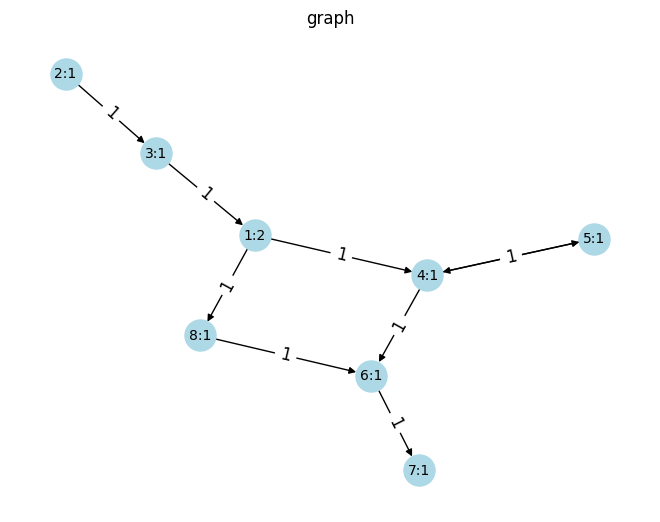

In [26]:
graph.visualise_short("graph")

In [ ]:
Graph(data[0]['graph']).visualise_short("graph")

In [ ]:
pipeline.invoke(data[0]['dialogues'], Graph(data[0]['graph']))